In [20]:
import math
import torch
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Fetch and preprocess data yf.download
ticker_symbol = 'NVDA'
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2025, 1, 1)


In [6]:
data = pd.read_csv('nvda_tf.csv',index_col='Date')


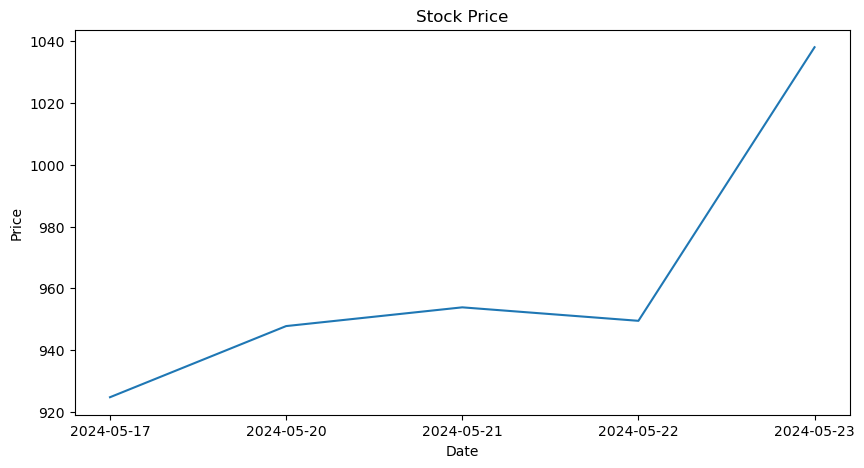

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(data['Close'].tail(5))
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [21]:
# Define your independent variables (features)
features = ['SMA_Signal', 'MACD_Signal', 'RSI_Signal', 'BB_Signal',
       'Stochastic_Signal', 'Combined_Signal', 'Volume']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize the features
data[features] = scaler.fit_transform(data[features])

In [10]:
data.iloc[599:601, -1]

Date
2024-05-22     949.50000
2024-05-23    1037.98999
Name: Close, dtype: float64

In [24]:
# Create sequences
sequence_length = 30

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])  # Features (excluding the "Close" price)
        y.append(data[i+sequence_length, -1])    # Target variable ("Close" price)
    return np.array(X), np.array(y) 
     
X, y = create_sequences(data.to_numpy(), sequence_length)

print('X Shape:', X.shape)
print('Y Shape:', y.shape)

X Shape: (571, 30, 7)
Y Shape: (571,)


In [25]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(456, 30, 7) (456,)
(57, 30, 7) (57,)
(58, 30, 7) (58,)


In [16]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


for X_batch, y_batch in train_loader:
    print(f'X_batch shape: {X_batch.shape}')
    print(f'y_batch shape: {y_batch.shape}')
    break  # Check the shape for one batch and exit

X_batch shape: torch.Size([32, 30, 7])
y_batch shape: torch.Size([32])


In [27]:
# Transformer

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()

        # Embedding layer
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.positional_encoding = self._init_positional_encoding(d_model, max_len=5000)
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(d_model, 1)

    def _init_positional_encoding(self, d_model, max_len):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        return pe

    def forward(self, x):
        x = self.embedding(x)
        seq_len = x.size(1)
        x += self.positional_encoding[:, :seq_len, :]
        x = self.transformer(x)
        x = self.fc_out(x[:, -1, :])  # Use the output from the last time step
        return x




In [31]:
# Time Series

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length, :-1]  # All columns except the last one (target)
        y = self.data[idx + self.seq_length - 1, -1]  # The last column (target)
        return x, y

In [28]:
# Hyperparameters
seq_length = 30
batch_size = 32
input_dim = len(data.columns) - 1  # Number of input features (excluding the target column)
d_model = 64  # Dimension of the embedding
nhead = 4  # Number of attention heads
num_layers = 2  # Number of transformer layers
dropout = 0.1  # Dropout rate
num_epochs = 5  # Number of epochs to train the model

In [32]:
# Define model, criterion, and optimizer
model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.metrics import r2_score

# Define the search space
space = [
    Real(0.001, 0.1, name='lr'),  # Learning rate
    Integer(2, 6, name='num_layers'),  # Number of layers
    Real(0.1, 0.5, name='dropout')  # Dropout rate
]

# Define the objective function
@use_named_args(space)
def objective(lr, num_layers, dropout):
    # Define model, criterion, and optimizer
    model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    # Validation loop
    
    # Calculate validation R2 score
    val_r2 = r2_score(val_targets, val_predictions)
    
    return -val_r2  # Minimize negative R2 score

# Run Bayesian optimization
res = gp_minimize(objective, space, n_calls=20, random_state=42)

# Get best hyperparameters
best_lr, best_num_layers, best_dropout = res.x

print("Best hyperparameters:")
print("Learning rate:", best_lr)
print("Number of layers:", best_num_layers)
print("Dropout rate:", best_dropout)


Best hyperparameters:
Learning rate: 0.07985775569916308
Number of layers: 3
Dropout rate: 0.41187640010910787


In [ ]:
# Define model with best hyperparameters
best_model = TimeSeriesTransformer(input_dim, d_model, nhead, best_num_layers, best_dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)

# Training loop for final model
for epoch in range(num_epochs):
    best_model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.float(), y_batch.float()
        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)




Final Test Loss: 86137.4095, Test R2: -0.0034


In [40]:
# Testing the final model
best_model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.float(), y_test_batch.float()
        test_outputs = best_model(X_test_batch)
        test_loss += criterion(test_outputs.squeeze(), y_test_batch).item() * X_test_batch.size(0)
        test_predictions.extend(test_outputs.squeeze().tolist())
        test_targets.extend(y_test_batch.tolist())

test_loss /= len(test_loader.dataset)
test_r2 = r2_score(test_targets, test_predictions)

print(f'Final Test Loss: {test_loss:.4f}, Test R2: {test_r2:.4f}')

Final Test Loss: 86137.4095, Test R2: -0.0034
